# Mark rooftops with u-net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate
from tensorflow.keras.optimizers import Adam

import keras.backend as K

### Load data

In [3]:
X = np.load("data/u_net_roofs/X_data.npy")
y = np.load("data/u_net_roofs/y_data.npy") 

#X = (X - X.mean(axis=0)) / X.std(axis=0)


n,r1,c1,d = y.shape
# Adds a new dimension of layer too have two class problem.
yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
for i in range(int(y.max()-1)):  
  yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
#yy[yy >= 0.001] = 1
yy1 = yy.copy()
yy1[:,:,:,0] = 0 # reset map
for i in range(n):
  values = yy[i,:,:,0]
  for r in range(r1):
    for c in range(c1):
      value = yy[i,r,c,0]
      yy1[i,r,c,int(value)] = 1


print(y.shape)
print(yy1.shape)

(100, 128, 128, 1)
(100, 128, 128, 3)


In [4]:
#X = X[:200]
#yy1 = yy1[:200]
#X.shape
X = X/100

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [6]:
X.shape

(100, 128, 128, 177)

### Make u net

In [7]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model



def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29 12 17 68 41]


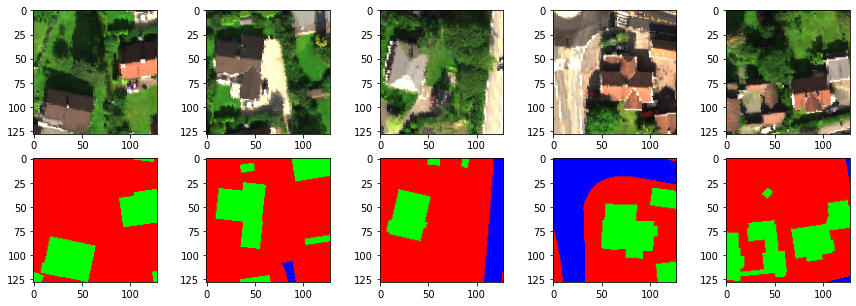

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (15,5))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
                              X_train[indx[i]][:,:,46],
                              X_train[indx[i]][:,:,21])))
    #PCAax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(y_train[indx[i]])
plt.show()

### Set up u net

In [9]:
input_img = Input(shape=(128,128,177))
uu = get_unet(input_img, n_classes=3)

uu.compile(optimizer=Adam(learning_rate=0.005),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [10]:
h = uu.fit(X_train, y_train, 
           validation_data=(X_test,y_test), 
           batch_size=20,
           epochs=200)

Epoch 1/200
4/4 [==============================] - 9s 487ms/step - loss: 0.8126 - accuracy: 0.6160 - val_loss: 1188.7942 - val_accuracy: 0.5012
Epoch 2/200
4/4 [==============================] - 1s 238ms/step - loss: 0.6288 - accuracy: 0.7216 - val_loss: 49712.2812 - val_accuracy: 0.5953
Epoch 3/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5853 - accuracy: 0.7477 - val_loss: 59664.6055 - val_accuracy: 0.5880
Epoch 4/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5325 - accuracy: 0.7943 - val_loss: 74230.3594 - val_accuracy: 0.6076
Epoch 5/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5056 - accuracy: 0.8016 - val_loss: 72391.5625 - val_accuracy: 0.5945
Epoch 6/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4580 - accuracy: 0.8338 - val_loss: 17591.7637 - val_accuracy: 0.5884
Epoch 7/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4530 - accuracy: 0.8271 - val_loss: 7105.7563 - val_accu

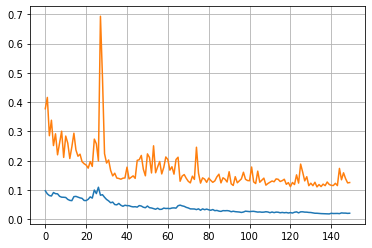

In [11]:
plt.plot(h.history['loss'][50:])
plt.plot(h.history['val_loss'][50:])
plt.grid()

### Test prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


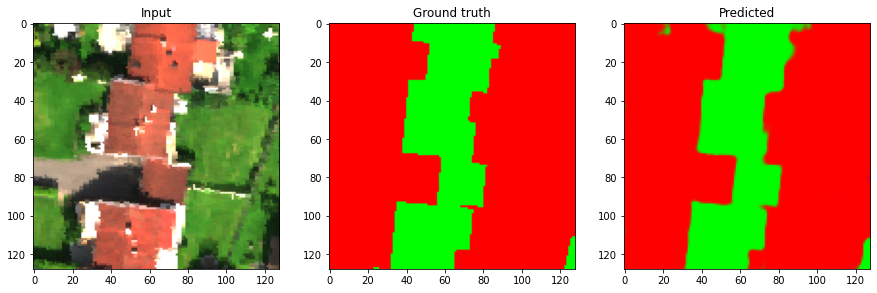

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


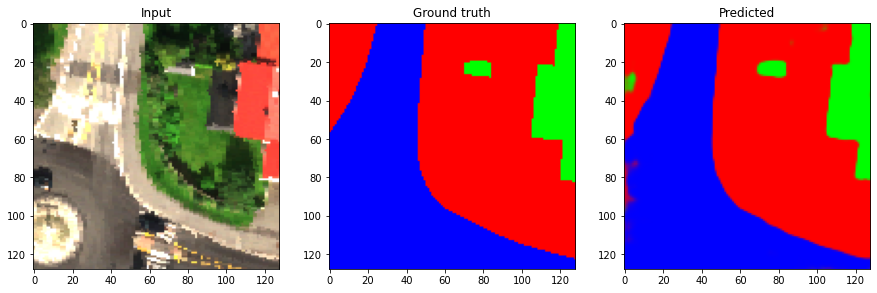

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


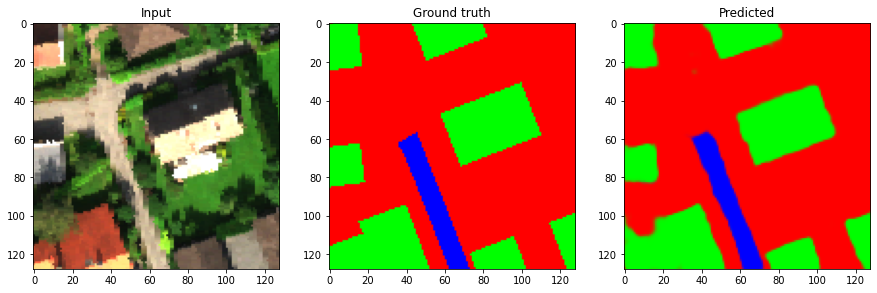

In [12]:
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21])))
  # PCA ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0])
  ax2.set_title("Ground truth")
  pred = uu.predict(X_test[x:x+1])[0]
  ax3.imshow(pred)
  ax3.set_title("Predicted")
  plt.show()

## Test on unseen data

In [39]:
X_unseen = np.load("data/u_net_roofs/X_data_unseen.npy")
y_unseen = np.load("data/u_net_roofs/y_data_unseen.npy")

y_unseen[y_unseen==3.0] = 1

# Adds a new dimension of layer too have two class problem.
n,r1,c1,d = y_unseen.shape
# Adds a new dimension of layer too have two class problem.
yy = np.append(y_unseen, np.zeros((n, r1, c1,d)), axis=3)
for i in range(int(y_unseen.max()-1)):  
  yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
#yy[yy >= 0.001] = 1
yy1 = yy.copy()
yy1[:,:,:,0] = 0 # reset map
for i in range(n):
  values = yy[i,:,:,0]
  for r in range(r1):
    for c in range(c1):
      value = yy[i,r,c,0]
      yy1[i,r,c,int(value)] = 1


print(y_unseen.shape)
print(yy1.shape)

(50, 128, 128, 1)
(50, 128, 128, 3)


In [40]:
X_unseen /= 100

In [41]:
pred = uu.predict(X_unseen)

In [42]:
from sklearn.metrics import balanced_accuracy_score

In [43]:
print("Metrics on whole pred and useen")
#print(f"f1 score: {f1_score(yy1.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {balanced_accuracy_score(yy1.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
acc score: 0.7200432181345026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


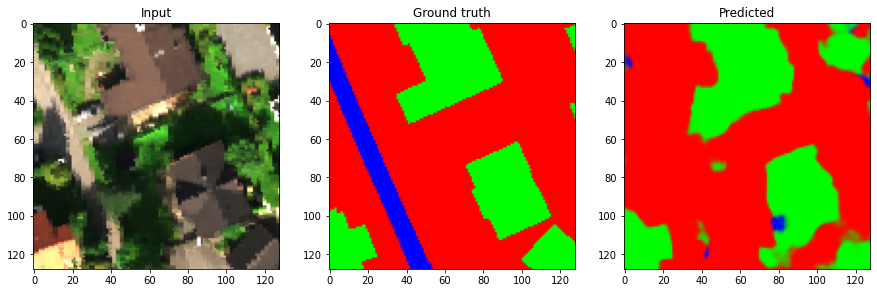

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.6079518405542109


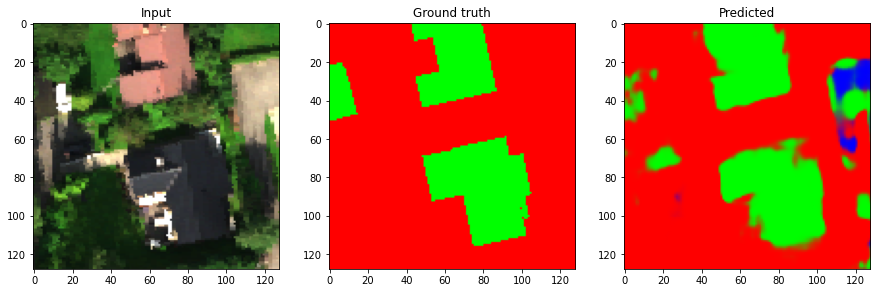

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.8966573608026138


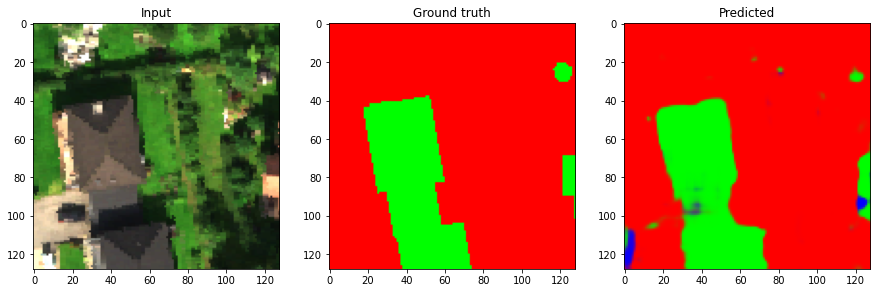

Acc score: 0.952984664291798


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [44]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_unseen[x:x+1][0][:,:,76],
                        X_unseen[x:x+1][0][:,:,46],
                        X_unseen[x:x+1][0][:,:,21])))
  # PCA ax1.imshow(X_unseen[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(yy1[x:x+1][0])
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0])
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {balanced_accuracy_score(yy1[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  #print(f"f1 score: {f1_score(yy1[x:x+1][0].argmax(axis=2).flatten(),\
  #                                   pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

In [ ]:
import seaborn as sns
sns.displot(pred[:,:,:,0])

ValueError: ignored

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)
